# Lab: CNN Tuning and Visualization

## Install and Update Packages

In [34]:
!pip install wandb --upgrade
!pip install grad-cam
!pip install matplotlib --upgrade

## Mount Drive

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/Lab Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Modules

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from multiprocessing import cpu_count
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import copy
import csv
import wandb
from pytorch_grad_cam import GradCAM

## Basic Configurations

In [77]:
# https://wandb.ai/site

wandb_args = dict(
    api_key = 'a1f7771022004b7f94c4289d17a75ca3fac48749', # Your API Key (access from settings)
    entity = 'fatima-yousif',  # Your W&B username
    project = 'lab_7'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr = 1e-4, wt = 1e-6,
    step = 5, gamma = 0.1,
    epochs = 10,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

## Preprocess Data

### Fetch the Dataset

In [38]:
!unzip -q "$root_dir""lidar_dataset.zip"
data_dir = '/content/dataset/'

mode = 'train'

replace dataset/train/door/fr52-door-3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


###Compute Mean and Standard Deviation for Normalization

In [79]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    mean /= samples
    std /= samples
    return mean, std

data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

###Define and Apply Transformations

In [80]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

###Split Data into Training and Validation Sets

In [81]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'], (train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

### Sample and Load the Datasets

In [82]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}

# sampler = None (question: 1)
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}

## Or Fetch and Preprocess Test Data (to Evaluate Pretrained Models)

In [43]:
# not needed for our model
# !unzip -q "$root_dir""lidar_test_dataset.zip"
# test_data_dir = '/content/test_dataset/'

# data_transforms = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
#             transforms.ToTensor(),
#         ])
# test_data = datasets.ImageFolder(test_data_dir, data_transforms)
# class_names = test_data.classes

# test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
# mode = 'test'

# Define the Network Architecture
### **Note:** Re-run this code cell each time you want to train the network from scratch!!

In [44]:
# HEIGHT and WIDTH
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [83]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()

        # def heightandwidth()
        # returns height and width to be used in the model below

        self.features = nn.Sequential(OrderedDict([
                            #######################
                            # Your Code Goes Here
                            #######################

                            # 1st layer
                            # input channels (b&w images)=1
                            # output channels = experiment with small number = 6
                            # kernel_size= filter= experimente (3x3) =9
                            # stride=2

                            # 2nd layer
                            # input = prev output = 16

                            # batch2d= imgs, conv, act
                            # batch1d= linear

                            # TODO: depth-wise

                              ('conv_0', nn.Conv2d(1, 6, kernel_size=9)),
                              ('relu_0', nn.ReLU()),
                              ('maxpool_0', nn.MaxPool2d(kernel_size=2, stride=2)),
                              ('batchnorm1',nn.BatchNorm2d(6)),    #batchnorm= before 1st conv2D bcz= input layer = ALREADY norm
                              ('conv_1', nn.Conv2d(6, 12, kernel_size=9)),
                              ('relu_1', nn.ReLU()),
                              ('maxpool_1', nn.MaxPool2d(kernel_size=2, stride=2))
                        ]))


        # norm= before each Conv2D = batch norm
        # learning = conv2D, batchnorm, linear
        # no learning = act, maxpool

        self.classifier = nn.Sequential(OrderedDict([
                            #######################
                            # Your Code Goes Here
                            #######################

                             ('FC0', nn.Linear(12*19*19, 100)),  # 19x19 = experiment or use heightandwidth is the output shape of maxpool_1
                             ('relu_2', nn.ReLU()),
                             ('batchnorm1c',nn.BatchNorm1d(100)),    #batchnorm= before 1st linear bcz= input layer = ALREADY norm
                             ('FC1', nn.Linear(100, num_classes)),
                             ('softmax', nn.Softmax(dim=1)),  # softmax layer added = no norm here bcz softmax alr normalizes.
                             ('FC2', nn.Linear(3, 3))
                        ]))

    def forward(self, x):
        out = self.features(x)          # extract features
        out = out.view(out.size(0),-1)  # flatten
        out = self.classifier(out)      # classify
        return out

net = LiNet()
print(net)

LiNet(
  (features): Sequential(
    (conv_0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu_0): ReLU()
    (maxpool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu_1): ReLU()
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (FC0): Linear(in_features=4332, out_features=100, bias=True)
    (relu_2): ReLU()
    (batchnorm1c): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (FC1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (FC2): Linear(in_features=3, out_features=3, bias=True)
  )
)


## Check if everything works correctly

In [84]:
# Create a dummy tensor of size (B x C x H x W)
dummy_input = torch.randn(2,1, 100, 100)  # B=1, C=1, H=100, W=100
#  B= 2 with batchnorm

# Pass it through the network
dummy_output = net(dummy_input)

# Print the shape of the output and verify if it is as expected
print(dummy_output.shape)

torch.Size([2, 3])


# **TRAIN AND VALIDATE - CNN**

Saving checkpoints in: /content/gdrive/My Drive/Lab Data/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab Data/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/10
----------
Train Loss: 0.9333 Acc: 0.5461
Val Loss: 0.8708 Acc: 0.6020

Epoch 2/10
----------
Train Loss: 0.7989 Acc: 0.9171
Val Loss: 0.7715 Acc: 0.9239

Epoch 3/10
----------
Train Loss: 0.6956 Acc: 0.9648
Val Loss: 0.6795 Acc: 0.9404

Epoch 4/10
----------
Train Loss: 0.6089 Acc: 0.9750
Val Loss: 0.6220 Acc: 0.9265

Epoch 5/10
----------
Train Loss: 0.5356 Acc: 0.9807
Val Loss: 0.5644 Acc: 0.9291

Epoch 6/10
----------
Train Loss: 0.4927 Acc: 0.9871
Val Loss: 0.5571 Acc: 0.9281

Epoch 7/10
----------
Train Loss: 0.4848 Acc: 0.9884
Val Loss: 0.5483 Acc: 0.9334

Epoch 8/10
----------
Train Loss: 0.4766 Acc: 0.9901
Val Loss: 0.5513 Acc: 0.9225

Epoch 9/10
----------
Train Loss: 0.4701 Acc: 0.9902
Val Loss: 0.5366 Acc: 0.9331

Epoch 10/10
----------
Train Loss: 0.4629 Acc: 0.9909
Val Loss: 0.5361 Acc: 0.9285

Training complete

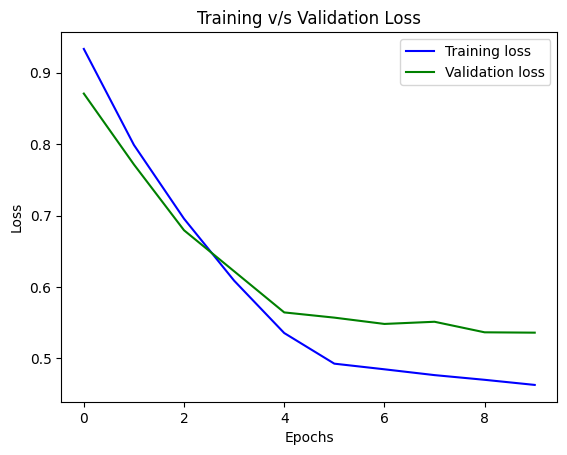

train_acc,▁▇████████
train_loss,█▆▄▃▂▁▁▁▁▁
val_acc,▁█████████
val_loss,█▆▄▃▂▁▁▁▁▁
train_acc,0.99094
train_loss,0.46292
val_acc,0.92846
val_loss,0.53609


In [85]:
import time

def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# **TWEAKING**

In [86]:
# https://wandb.ai/site

wandb_args = dict(
    api_key = 'a1f7771022004b7f94c4289d17a75ca3fac48749', # Your API Key (access from settings)
    entity = 'fatima-yousif',  # Your W&B username
    project = 'lab_7'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr = 1e-3, # increase
    wt = 1e-6,
    step = 5,
    gamma = 0.1,
    epochs = 20, # increase
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()

        # def heightandwidth()
        # returns height and width to be used in the model below

        self.features = nn.Sequential(OrderedDict([
                            #######################
                            # Your Code Goes Here
                            #######################

                            # 1st layer
                            # input channels (b&w images)=1
                            # output channels = experiment with small number = 6
                            # kernel_size= filter= experimente (3x3) =9
                            # stride=2

                            # 2nd layer
                            # input = prev output = 16

                            # batch2d= imgs, conv, act
                            # batch1d= linear

                            # TODO: depth-wise

                              ('conv_0', nn.Conv2d(1, 6, kernel_size=9)),
                              ('relu_0', nn.ReLU()),
                              ('maxpool_0', nn.MaxPool2d(kernel_size=2, stride=2)),
                              ('batchnorm1',nn.BatchNorm2d(6)),    #batchnorm= before 1st conv2D bcz= input layer = ALREADY norm
                              ('conv_1', nn.Conv2d(6, 12, kernel_size=9)),
                              ('relu_1', nn.ReLU()),
                              ('maxpool_1', nn.MaxPool2d(kernel_size=2, stride=2))
                        ]))


        # norm= before each Conv2D = batch norm
        # learning = conv2D, batchnorm, linear
        # no learning = act, maxpool

        self.classifier = nn.Sequential(OrderedDict([
                            #######################
                            # Your Code Goes Here
                            #######################

                             ('FC0', nn.Linear(12*19*19, 100)),  # 19x19 = experiment or use heightandwidth is the output shape of maxpool_1
                             ('relu_2', nn.ReLU()),
                             ('batchnorm1c',nn.BatchNorm1d(100)),    #batchnorm= before 1st linear bcz= input layer = ALREADY norm
                             ('FC1', nn.Linear(100, num_classes)),
                             ('softmax', nn.Softmax(dim=1)),  # softmax layer added = no norm here bcz softmax alr normalizes.
                             ('FC2', nn.Linear(3, 3))
                        ]))

    def forward(self, x):
        out = self.features(x)          # extract features
        out = out.view(out.size(0),-1)  # flatten
        out = self.classifier(out)      # classify
        return out

net2 = LiNet()
print(net2)

LiNet(
  (features): Sequential(
    (conv_0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu_0): ReLU()
    (maxpool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu_1): ReLU()
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (FC0): Linear(in_features=4332, out_features=100, bias=True)
    (relu_2): ReLU()
    (batchnorm1c): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (FC1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (FC2): Linear(in_features=3, out_features=3, bias=True)
  )
)


In [87]:
# Create a dummy tensor of size (B x C x H x W)
dummy_input = torch.randn(2,1, 100, 100)  # B=1, C=1, H=100, W=100
#  B= 2 with batchnorm

# Pass it through the network
dummy_output = net2(dummy_input)

# Print the shape of the output and verify if it is as expected
print(dummy_output.shape)

torch.Size([2, 3])


##And (optionally) load a pretrained model

In [50]:
# state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
# net.load_state_dict(state_dict)
# net.eval()

# Determine the number of Parameters

In [88]:
param_count = sum(p.numel() for p in net.parameters()) / 1000000
print('\nTotal Parameter Count - CNN: %.2f M' % param_count)

param_count = sum(p.numel() for p in net2.parameters()) / 1000000
print('\nTotal Parameter Count - CNN tweaked: %.2f M' % param_count)


Total Parameter Count - CNN: 0.44 M

Total Parameter Count - CNN tweaked: 0.44 M


### Can you determine the number of parametres in the feature extractor?

In [89]:
f_extractor_num_params = sum(p.numel() for p in net.features.parameters())
print("Number of parameters in the feature extractor - CNN:", f_extractor_num_params)

f_extractor_num_params = sum(p.numel() for p in net2.features.parameters())
print("Number of parameters in the feature extractor - CNN tweaked:", f_extractor_num_params)

Number of parameters in the feature extractor - CNN: 6348
Number of parameters in the feature extractor - CNN tweaked: 6348


#Train and Validate

### **Note**: Re-run the code cell that defines the network architecture before starting a new run!!

Saving checkpoints in: /content/gdrive/My Drive/Lab Data/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab Data/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/20
----------
Train Loss: 0.3615 Acc: 0.9382
Val Loss: 0.3057 Acc: 0.9231

Epoch 2/20
----------
Train Loss: 0.1817 Acc: 0.9639
Val Loss: 0.2314 Acc: 0.9379

Epoch 3/20
----------
Train Loss: 0.1123 Acc: 0.9764
Val Loss: 0.3621 Acc: 0.8850

Epoch 4/20
----------
Train Loss: 0.0798 Acc: 0.9829
Val Loss: 0.2069 Acc: 0.9440

Epoch 5/20
----------
Train Loss: 0.0595 Acc: 0.9871
Val Loss: 0.2714 Acc: 0.9241

Epoch 6/20
----------
Train Loss: 0.0382 Acc: 0.9934
Val Loss: 0.2299 Acc: 0.9395

Epoch 7/20
----------
Train Loss: 0.0306 Acc: 0.9954
Val Loss: 0.2813 Acc: 0.9263

Epoch 8/20
----------
Train Loss: 0.0271 Acc: 0.9963
Val Loss: 0.2739 Acc: 0.9285

Epoch 9/20
----------
Train Loss: 0.0256 Acc: 0.9966
Val Loss: 0.2641 Acc: 0.9336

Early stopping! Completed in 13m 9s
Best val Acc: 0.943951



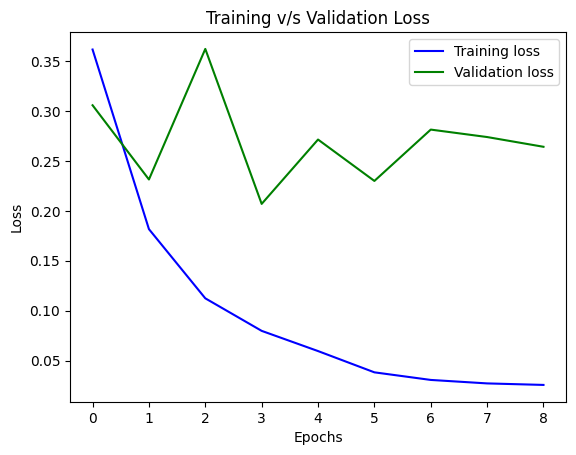

train_acc,▁▄▆▆▇████
train_loss,█▄▃▂▂▁▁▁▁
val_acc,▆▇▁█▆▇▆▆▇
val_loss,▅▂█▁▄▂▄▄▄
train_acc,0.99662
train_loss,0.02562
val_acc,0.9336
val_loss,0.26412


In [90]:
import time

def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net2 = net2.to(device)
net2, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# ***Depth-Separable Convolutions***

In [99]:
import torch.nn as nn
from collections import OrderedDict

wandb_args = dict(
    api_key = 'a1f7771022004b7f94c4289d17a75ca3fac48749', # Your API Key (access from settings)
    entity = 'fatima-yousif',  # Your W&B username
    project = 'lab_7'
)

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([

            # groups = nin (1st/2nd param of Conv2d)

            ('depthwise_conv_0', nn.Conv2d(1, 1, kernel_size=9, groups=1)),  # Depth Separable convolution
            ('pointwise_conv_0', nn.Conv2d(1, 6, kernel_size=1)),
            ('relu_0', nn.ReLU()),
            ('maxpool_0', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('batchnorm1', nn.BatchNorm2d(6)),

            # groups = nin (1st/2nd param of Conv2d)

            ('depthwise_conv_1', nn.Conv2d(6, 6, kernel_size=9, groups=6)),  # Depth Separable convolution
            ('pointwise_conv_1', nn.Conv2d(6, 12, kernel_size=1)),
            ('relu_1', nn.ReLU()),
            ('maxpool_1', nn.MaxPool2d(kernel_size=2, stride=2))
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('FC0', nn.Linear(12*19*19, 100)),
            ('relu_2', nn.ReLU()),
            ('batchnorm1c', nn.BatchNorm1d(100)),
            ('FC1', nn.Linear(100, num_classes)),
            ('softmax', nn.Softmax(dim=1)),
            ('FC2', nn.Linear(3, 3))
        ]))

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

netD = LiNet()
print(netD)

LiNet(
  (features): Sequential(
    (depthwise_conv_0): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1))
    (pointwise_conv_0): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
    (relu_0): ReLU()
    (maxpool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise_conv_1): Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1), groups=6)
    (pointwise_conv_1): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1))
    (relu_1): ReLU()
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (FC0): Linear(in_features=4332, out_features=100, bias=True)
    (relu_2): ReLU()
    (batchnorm1c): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (FC1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (FC2): Linear(in_features=3, ou

In [100]:
# Create a dummy tensor of size (B x C x H x W)
dummy_input = torch.randn(2,1, 100, 100)  # B=1, C=1, H=100, W=100
#  B= 2 with batchnorm

# Pass it through the network
dummy_output = netD(dummy_input)

# Print the shape of the output and verify if it is as expected
print(dummy_output.shape)

torch.Size([2, 3])


In [101]:
param_count = sum(p.numel() for p in netD.parameters()) / 1000000
print('\nTotal Parameter Count - DSC: %.2f M' % param_count)


Total Parameter Count - DSC: 0.43 M


In [102]:
f_extractor_num_params = sum(p.numel() for p in netD.features.parameters())
print("Number of parameters in the feature extractor:", f_extractor_num_params)

Number of parameters in the feature extractor: 682


Saving checkpoints in: /content/gdrive/My Drive/Lab Data/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab Data/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/20
----------
Train Loss: 0.0465 Acc: 0.9890
Val Loss: 0.2446 Acc: 0.9367

Epoch 2/20
----------
Train Loss: 0.0376 Acc: 0.9912
Val Loss: 0.3217 Acc: 0.9213

Epoch 3/20
----------
Train Loss: 0.0304 Acc: 0.9928
Val Loss: 0.2881 Acc: 0.9285

Epoch 4/20
----------
Train Loss: 0.0240 Acc: 0.9941
Val Loss: 0.4804 Acc: 0.8848

Epoch 5/20
----------
Train Loss: 0.0228 Acc: 0.9944
Val Loss: 0.2915 Acc: 0.9310

Epoch 6/20
----------
Train Loss: 0.0120 Acc: 0.9977
Val Loss: 0.3009 Acc: 0.9300

Early stopping! Completed in 9m 37s
Best val Acc: 0.936703



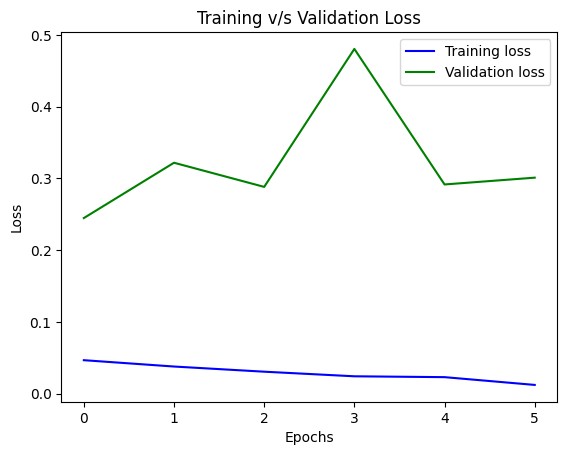

train_acc,▁▃▄▅▅█
train_loss,█▆▅▃▃▁
val_acc,█▆▇▁▇▇
val_loss,▁▃▂█▂▃
train_acc,0.99768
train_loss,0.01199
val_acc,0.93003
val_loss,0.30094


In [103]:
import time

def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

netD = netD.to(device)
netD, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Evaluate the Model

In [104]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-xxx-accuracy.txt"

evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 96.5368%
	Accuracy of corridor : 95.7239%
	Accuracy of door : 94.7604%
	Accuracy of room : 99.0297%

Kappa Score: 0.9480

               precision    recall  f1-score   support

    corridor       0.97      0.96      0.96      1637
        door       0.96      0.95      0.95      1565
        room       0.97      0.99      0.98      1649

    accuracy                           0.97      4851
   macro avg       0.97      0.97      0.97      4851
weighted avg       0.97      0.97      0.97      4851



In [105]:
!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-tweak-xxx-accuracy.txt"

evaluate_model(net2, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 96.9079%
	Accuracy of corridor : 96.5371%
	Accuracy of door : 94.8846%
	Accuracy of room : 99.3134%

Kappa Score: 0.9536

               precision    recall  f1-score   support

    corridor       0.97      0.97      0.97      1646
        door       0.97      0.95      0.96      1603
        room       0.97      0.99      0.98      1602

    accuracy                           0.97      4851
   macro avg       0.97      0.97      0.97      4851
weighted avg       0.97      0.97      0.97      4851



In [106]:
!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-D-xxx-accuracy.txt"

evaluate_model(netD, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 96.4337%
	Accuracy of corridor : 96.2895%
	Accuracy of door : 93.3376%
	Accuracy of room : 99.4582%

Kappa Score: 0.9465

               precision    recall  f1-score   support

    corridor       0.96      0.96      0.96      1644
        door       0.97      0.93      0.95      1546
        room       0.96      0.99      0.98      1661

    accuracy                           0.96      4851
   macro avg       0.96      0.96      0.96      4851
weighted avg       0.96      0.96      0.96      4851



# Estimate the Inference Speed

In [107]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.4f s' % inference_speed)
    print('Throughput: %d images' % throughput)


get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.0000 s
Throughput: 29154 images


In [108]:
print("CNN tweaked:")
get_fps(net2, dataloaders['test'] if mode=='train' else test_dataloader)
print("DSC:")
get_fps(netD, dataloaders['test'] if mode=='train' else test_dataloader)

CNN tweaked:
Inference speed: 0.0000 s
Throughput: 56874 images
DSC:
Inference speed: 0.0000 s
Throughput: 23328 images


# Make Predictions

CNN:


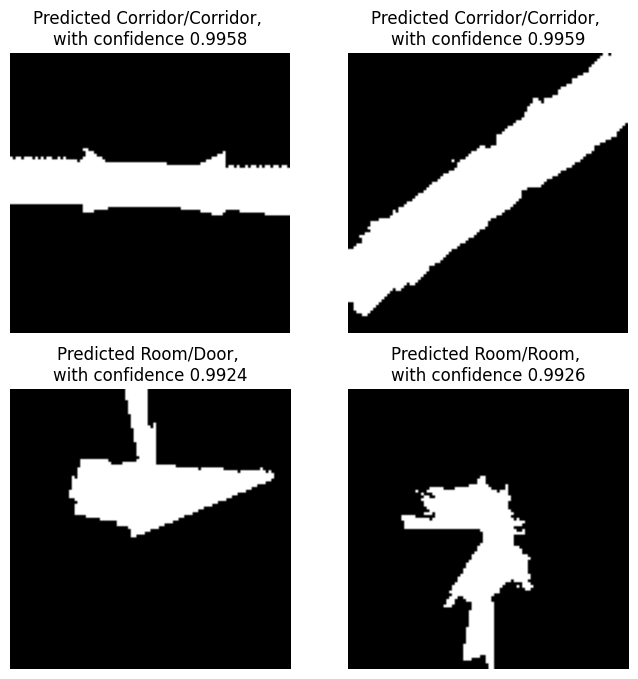

In [110]:
def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

print("CNN:")
predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

CNN tweaked:


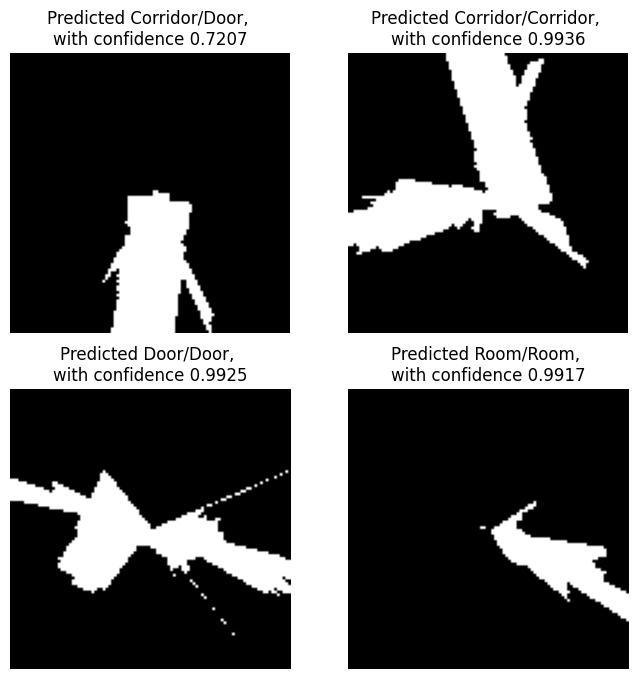

In [111]:
print("CNN tweaked:")
predict(net2, dataloaders['test'] if mode=='train' else test_dataloader)

DSC:


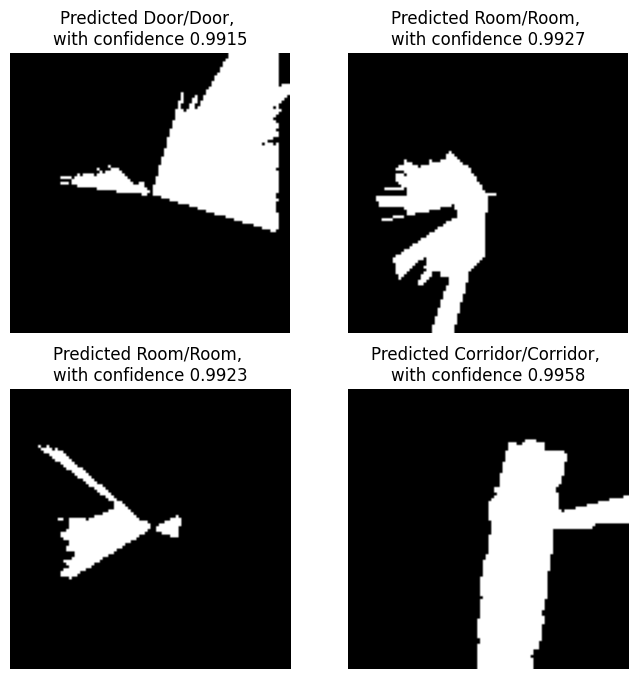

In [112]:
print("DSC:")
predict(netD, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Filters (Features) and Activations (Feature Maps)

In [114]:
def get_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)):
            conv_layers.append(module)
        elif type(module)==nn.Sequential:
            conv_layers.extend(get_convs(module.children()))
    return conv_layers

convs = get_convs(net.features)
for conv in convs:
    print(f'CONV: {conv} => SHAPE: {conv.weight.shape}')


convs1 = get_convs(net2.features)
for conv in convs1:
    print(f'Tweaked CONV: {conv} => SHAPE: {conv.weight.shape}')


convs2 = get_convs(netD.features)
for conv in convs2:
    print(f'DSC: {conv} => SHAPE: {conv.weight.shape}')

CONV: Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 9, 9])
CONV: Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([12, 6, 9, 9])
Tweaked CONV: Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 9, 9])
Tweaked CONV: Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([12, 6, 9, 9])
DSC: Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 9, 9])
DSC: Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([12, 6, 9, 9])


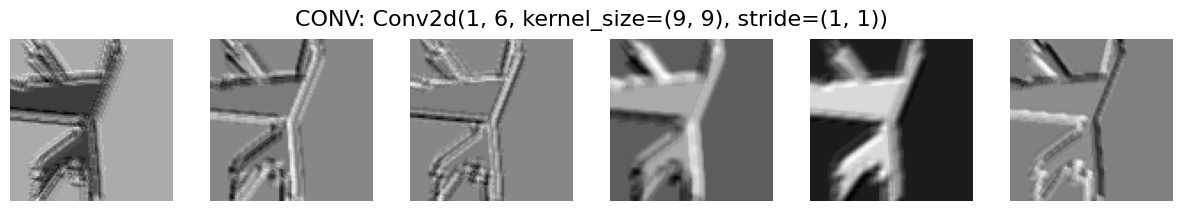

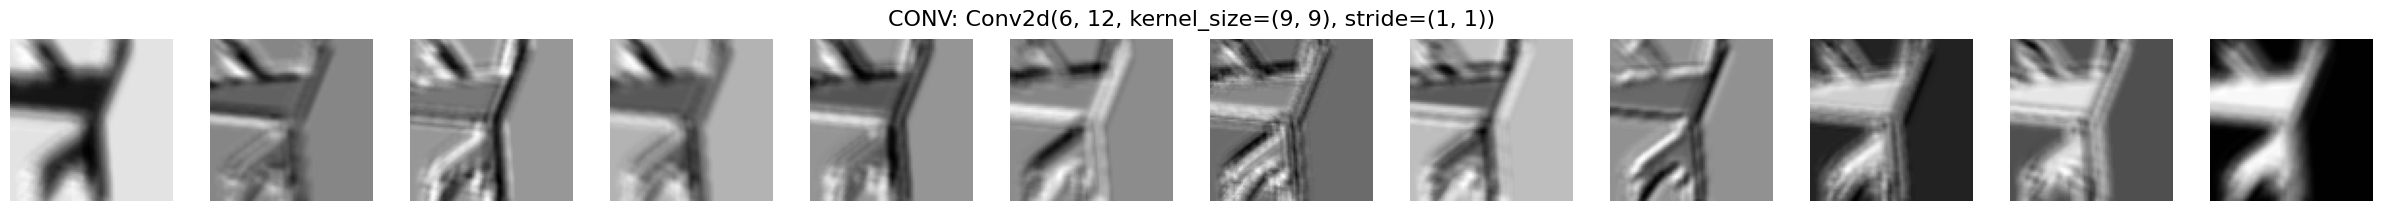

In [115]:
def visualize_activations(convs, dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x H x W
        img = inputs[:1]

        activations = [convs[0](img)]
        for i in range(1, len(convs)):
            activations.append(convs[i](activations[-1]))

        for conv, act in zip(convs, activations):
            out_ch = conv.out_channels
            fig = plt.figure(figsize=(out_ch*2, 2), constrained_layout=True)
            fig.suptitle(f'CONV: {conv}', size=16)
            for j in range(out_ch):
                ax = plt.subplot(1, out_ch, j+1)
                ax.axis('off')
                ax.imshow(act.detach().squeeze()[j].cpu(), cmap='gray')
                # Dim --> B x Out Ch x H' x W'
        return


visualize_activations(convs, dataloaders['test'] if mode=='train' else test_dataloader)

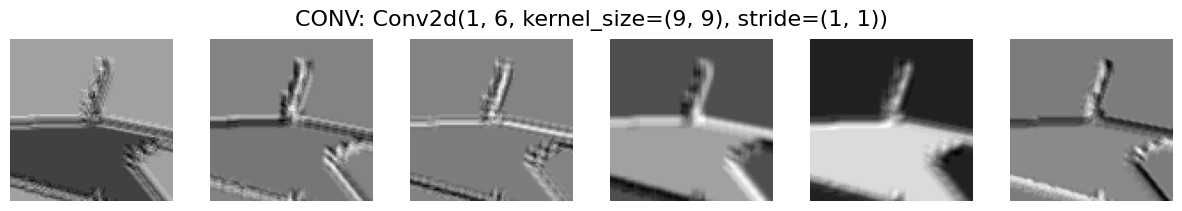

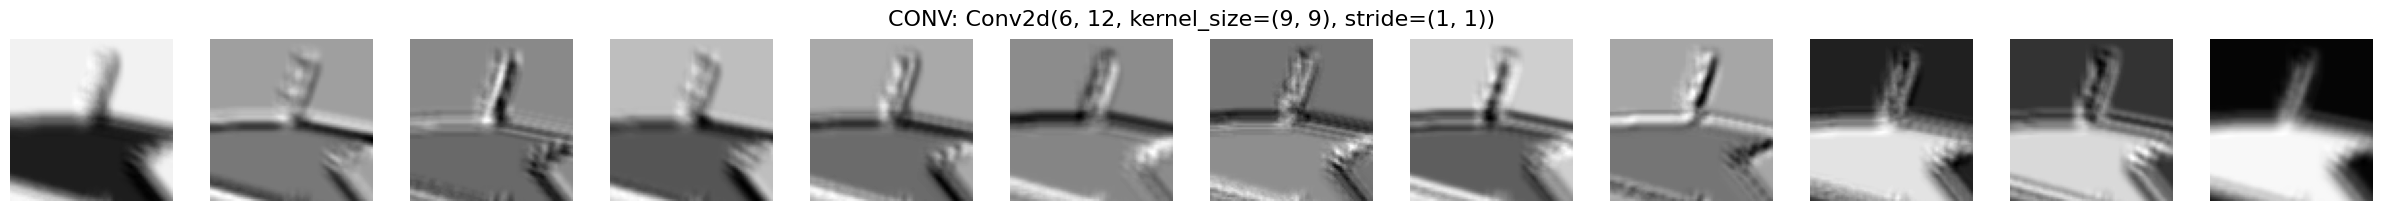

In [116]:
# tweaked CNN
visualize_activations(convs1, dataloaders['test'] if mode=='train' else test_dataloader)

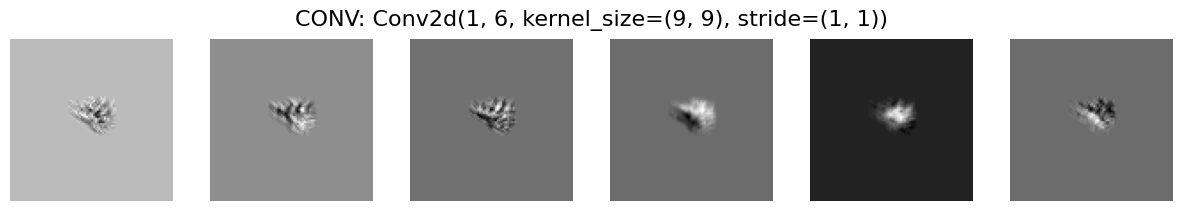

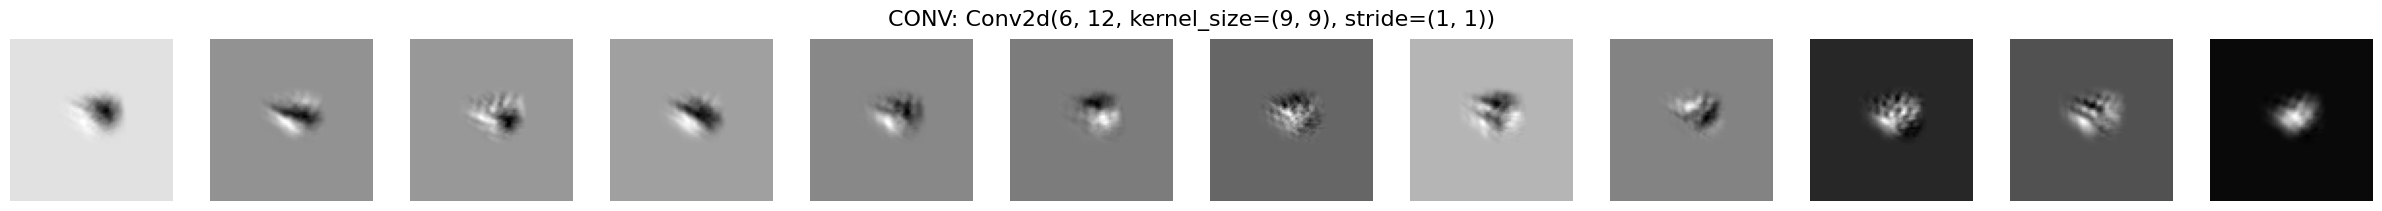

In [117]:
# DSC
visualize_activations(convs2, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Grad-CAMs

<ipython-input-118-4a3271217e57>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


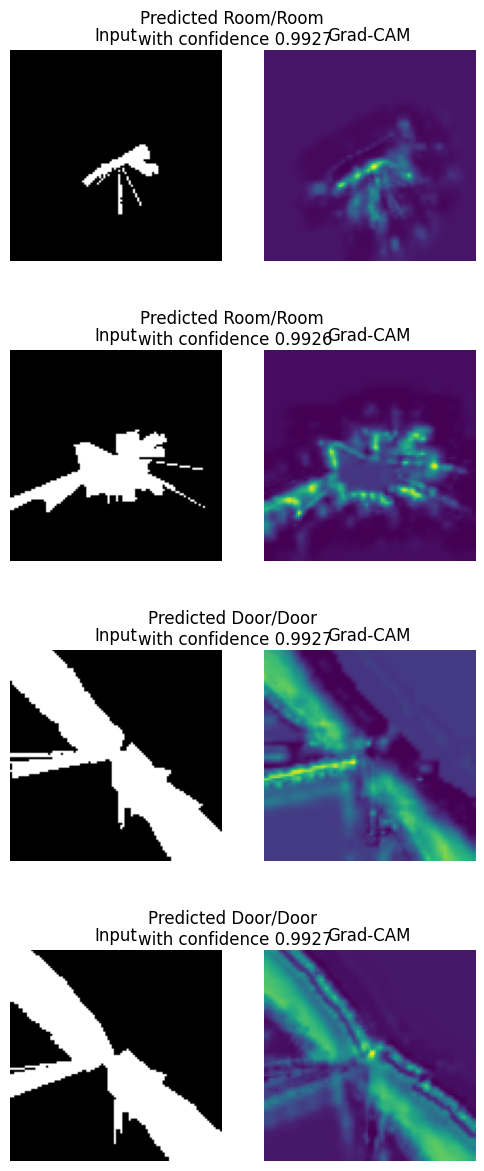

In [118]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    cam = GradCAM(model=model, target_layers=model.features, use_cuda=False)

    fig = plt.figure(constrained_layout=True, figsize=(6,12))
    fig.tight_layout()
    subfigs = fig.subfigures(nrows=num_images, ncols=1)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)                      # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)                         # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1,True)                   # B x classes

        masks = cam(input_tensor=inputs[:num_images])

        for j in range(inputs.size()[0]):
            axs = subfigs[j].subplots(1, 2)
            subfigs[j].suptitle('Predicted {1}/{2} \nwith confidence {0:.4f}'.format(prob[j][0],
                class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
            axs[0].axis('off')
            axs[0].set_title('Input')
            axs[0].imshow(inputs[j].cpu().squeeze(), cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Grad-CAM')
            axs[1].imshow(masks[j])

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)

visualize(net, dataloaders['test'] if mode=='train' else test_dataloader)

<ipython-input-118-4a3271217e57>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


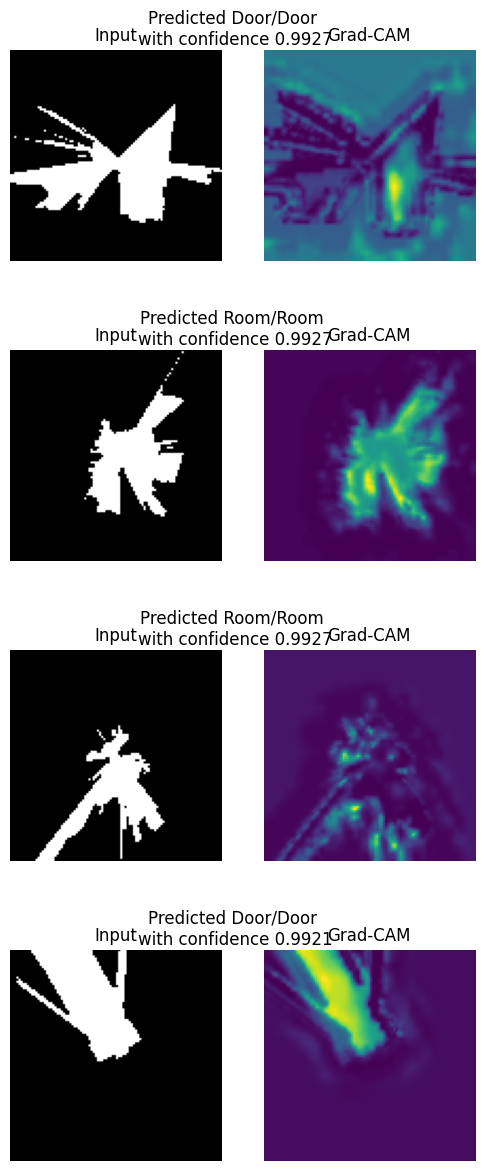

In [119]:
# tweaked CNN
visualize(net2, dataloaders['test'] if mode=='train' else test_dataloader)

<ipython-input-118-4a3271217e57>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


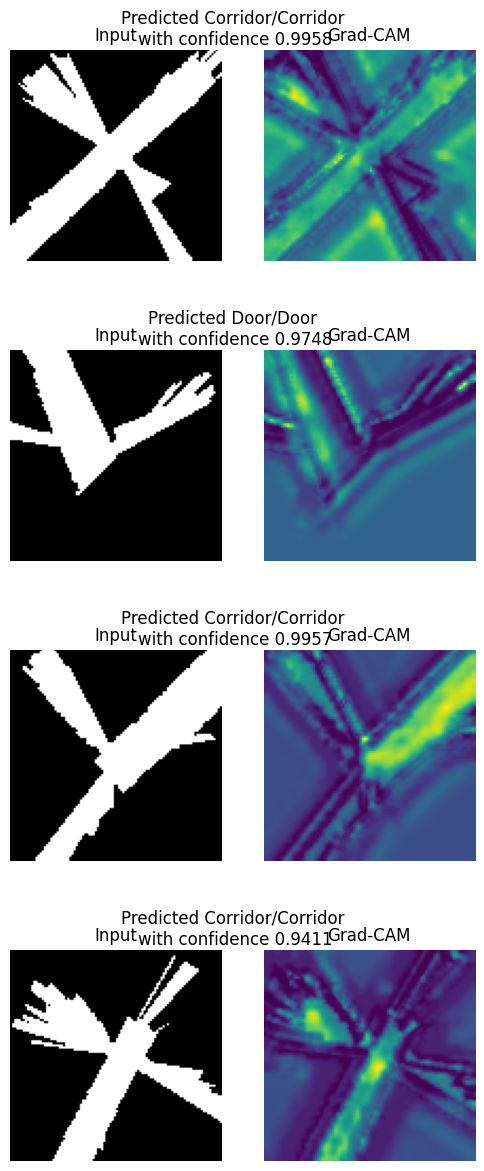

In [120]:
# DSC
visualize(netD, dataloaders['test'] if mode=='train' else test_dataloader)

#Save the Trained Model

In [121]:
# CNN
torch.save(net.state_dict(),root_dir+'<new_name_for_each_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [122]:
# Tweaked CNN
torch.save(net2.state_dict(),root_dir+'<new_name_for_each_model>.pth')

with open(root_dir+'LiNet_tweaked_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [123]:
# DSC
torch.save(netD.state_dict(),root_dir+'<new_name_for_each_model>.pth')

with open(root_dir+'LiNet_d_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

# ***QUESTIONS***

● Does accounting for class imbalance really have an effect on model performance? Try it out! (Hint: Set the “sampler” argument to None)

Yes, accounting for class imbalance can have a significant effect on the model performance. As worked in cells above, in such cases, models may become biased towards the majority class, leading to poor performance on minority classes.

When loading the data with no sampler:

```
# sampler = None
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=None)
                for x in ['train','val','test']}
```



---


● Identify the main sources of ambiguity for the model, if any. Try running a couple predictions and observing the cases where the model makes mistakes.


The main sources of ambiguity from above ran cells for predictions proved that low confidence score for a particular prediction suggests the model is unsure about its prediction, as it happened with first case of (shown in the output of above predict() cell)

---



● Do you think increasing the receptive field would have a major effect on performance? Try stacking convolutions or perhaps dilated convolutions to save up on learnable parameters ;)


In the context of convolutional neural networks (CNNs), a larger receptive field can capture more global features and contextual information from the input, potentially improving the model's ability to understand complex patterns for producing better output results.